In [3]:
#loading the data 
import pandas as pd
import yfinance as yf

tickers = ["AAPL", "TSLA", "JPM", "XOM", "JNJ", "SPY", "NVDA", "CAT"]
start_date = "2023-01-01"
end_date = "2024-01-01"

data_all={}

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data_all[ticker] = data



C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\933510313.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\933510313.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\933510313.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\933510313.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, s

In [4]:
print(data_all["AAPL"].head())

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.470612  129.226052  122.582119  128.613985  112117500
2023-01-04  124.744102  127.014693  123.480472  125.267324   89113600
2023-01-05  123.421265  126.136098  123.164595  125.504283   80962700
2023-01-06  127.962418  128.623848  123.292909  124.398589   87754700
2023-01-09  128.485626  131.703947  128.228957  128.801541   70790800


In [5]:
data_all["NVDA"].describe()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
count,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,36.546598,37.100123,35.904290,36.492551,4.735575e+08
std,10.753172,10.913559,10.654499,10.845758,1.614028e+08
min,14.252333,14.551067,14.021536,14.461145,1.982090e+08
25%,26.880426,27.151479,26.409514,26.811726,3.790238e+08
50%,41.869457,42.480360,40.940679,41.611605,4.341845e+08
75%,45.619115,46.198625,44.963364,45.743542,5.172652e+08
max,50.382153,50.521078,49.390022,50.185119,1.543911e+09


In [6]:
import mplfinance as mpf
for ticker, df in data_all.items():
    print(f"\n📊 Plotting {ticker}...")


    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    df.index.name = "Date"

    
    mpf.plot(
        df,
        type="candle",
        style="charles",
        title=f"{ticker} - Full Candlestick Chart",
        ylabel="Price (USD)",
        volume=True,
        mav=(20, 50),
        show_nontrading=False,
        figratio=(16, 9),
        figscale=1.5,
        savefig=dict(fname=f"charts/{ticker}_candlestick_full.png", dpi=300, bbox_inches='tight')
)




📊 Plotting AAPL...

📊 Plotting TSLA...

📊 Plotting JPM...

📊 Plotting XOM...

📊 Plotting JNJ...

📊 Plotting SPY...

📊 Plotting NVDA...

📊 Plotting CAT...


In [7]:
import numpy as np

log_returns_all = {}

for ticker, df in data_all.items():
    df = df.copy()
    df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
    df.dropna(inplace=True)
    log_returns_all[ticker] = df


In [ ]:
volatility_all = {}

for ticker, df in log_returns_all.items():
    daily_std = df["LogReturn"].std()
    annualized_vol = daily_std * np.sqrt(252) 
    volatility_all[ticker] = annualized_vol
    print(f"{ticker} Volatility: {annualized_vol:.4f}")


AAPL Volatility: 0.1992
TSLA Volatility: 0.5239
JPM Volatility: 0.2076
XOM Volatility: 0.2486
JNJ Volatility: 0.1652
SPY Volatility: 0.1308
NVDA Volatility: 0.4679
CAT Volatility: 0.2854


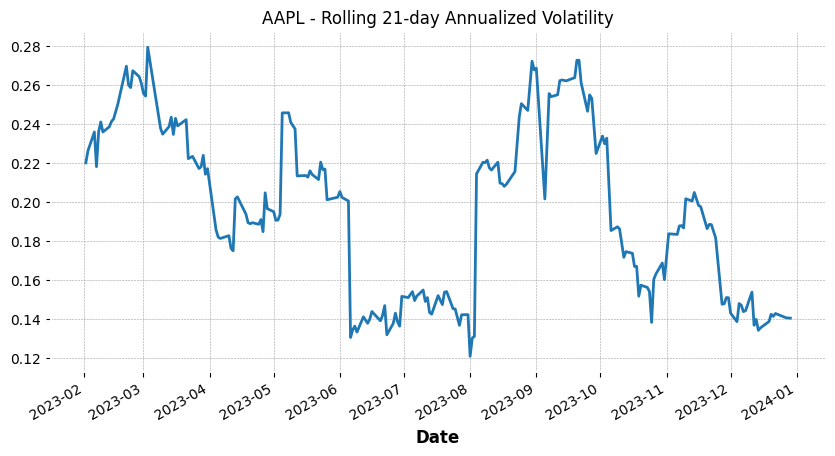

In [9]:
import matplotlib.pyplot as plt

ticker = "AAPL"
log_returns_all[ticker]["RollingVolatility"] = log_returns_all[ticker]["LogReturn"].rolling(window=21).std() * np.sqrt(252)

log_returns_all[ticker]["RollingVolatility"].plot(title=f"{ticker} - Rolling 21-day Annualized Volatility", figsize=(10, 5))
plt.grid(True)
plt.show()


In [ ]:

from scipy.stats import norm
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

In [ ]:
option_results = []
r = 0.05  

for ticker, df in log_returns_all.items():
    S = df["Close"].iloc[-1]
    sigma = volatility_all[ticker]

    for T_days in [30, 60, 90,120, 150, 180]:
        T = T_days / 252
        K = round(S * 1.05, 2)  

        price = black_scholes_price(S, K, T, r, sigma, option_type='call')

        option_results.append({
            "Ticker": ticker,
            "S": S,
            "K": K,
            "T_days": T_days,
            "Volatility": sigma,
            "BSM Price": price
        })

import pandas as pd
results_df = pd.DataFrame(option_results)
print(results_df.head())

  Ticker                                                  S  \
0   AAPL  Ticker
AAPL    191.130341
Name: 2023-12-29 00:...   
1   AAPL  Ticker
AAPL    191.130341
Name: 2023-12-29 00:...   
2   AAPL  Ticker
AAPL    191.130341
Name: 2023-12-29 00:...   
3   AAPL  Ticker
AAPL    191.130341
Name: 2023-12-29 00:...   
4   AAPL  Ticker
AAPL    191.130341
Name: 2023-12-29 00:...   

                                                   K  T_days  Volatility  \
0  Ticker
AAPL    200.69
Name: 2023-12-29 00:00:0...      30    0.199222   
1  Ticker
AAPL    200.69
Name: 2023-12-29 00:00:0...      60    0.199222   
2  Ticker
AAPL    200.69
Name: 2023-12-29 00:00:0...      90    0.199222   
3  Ticker
AAPL    200.69
Name: 2023-12-29 00:00:0...     120    0.199222   
4  Ticker
AAPL    200.69
Name: 2023-12-29 00:00:0...     150    0.199222   

                                           BSM Price  
0  Ticker
AAPL    2.178277
Name: 2023-12-29 00:00...  
1  Ticker
AAPL    4.493233
Name: 2023-12-29 00:00...  

In [12]:
print(results_df.iloc[:1,2])

0    Ticker
AAPL    200.69
Name: 2023-12-29 00:00:0...
Name: K, dtype: object


In [13]:
def plot_price_vs_time(df, ticker):
    subset = df[df["Ticker"] == ticker]
    plt.figure(figsize=(10, 5))
    plt.plot(subset["T_days"], subset["BSM Price"], marker='o', linestyle='-')
    plt.title(f"Option Price vs. Time to Expiry ({ticker})")
    plt.xlabel("Days to Expiry")
    plt.ylabel("BSM Price")
    plt.grid(True)
    plt.savefig(f"charts/{ticker}_price_vs_time.png", dpi=300)
    plt.show()
    plt.close()

def plot_price_vs_strike(S, T, sigma, r, ticker):
    strikes = np.linspace(S * 0.9, S * 1.1, 50)
    prices = [black_scholes_price(S, K, T, r, sigma) for K in strikes]
    plt.figure(figsize=(10, 5))
    plt.plot(strikes, prices, linestyle='-', color='purple')
    plt.title(f"Option Price vs. Strike Price ({ticker})")
    plt.xlabel("Strike Price (K)")
    plt.ylabel("BSM Price")
    plt.grid(True)
    plt.savefig(f"charts/{ticker}_price_vs_strike.png", dpi=300)
    plt.show()
    plt.close()


In [ ]:
def plot_price_vs_time_multi_strikes(S, sigma, r, ticker, strike_multipliers=[0.95, 1.0, 1.05, 1.1]):
    T_days_range = np.arange(10, 181, 10)
    T_range = T_days_range / 252

    plt.figure(figsize=(10, 6))

    for m in strike_multipliers:
        K = round(S * m, 2)
        prices = [black_scholes_price(S, K, T, r, sigma) for T in T_range]
        plt.plot(T_days_range, prices, marker='o', label=f"Strike: {K}")

    plt.title(f"BSM Option Price vs. Time to Expiry ({ticker})")
    plt.xlabel("Days to Expiry")
    plt.ylabel("BSM Price")
    plt.grid(True)
    plt.legend(title="Strikes", title_fontsize="medium", fontsize="small")
    plt.tight_layout()
    plt.savefig(f"charts/{ticker}_price_vs_time_multi_strikes.png", dpi=300)
    plt.show()
    plt.close()


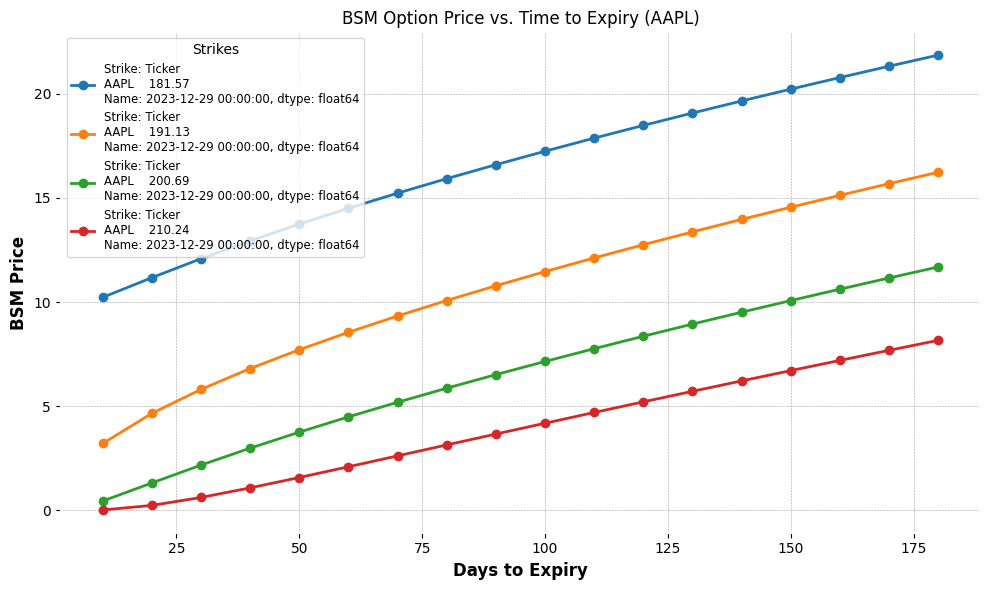

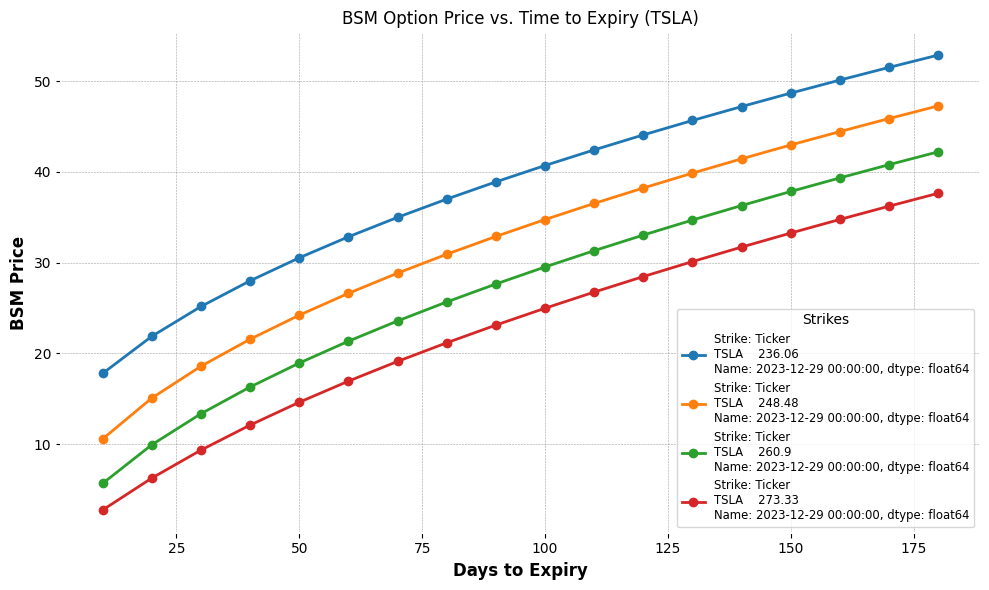

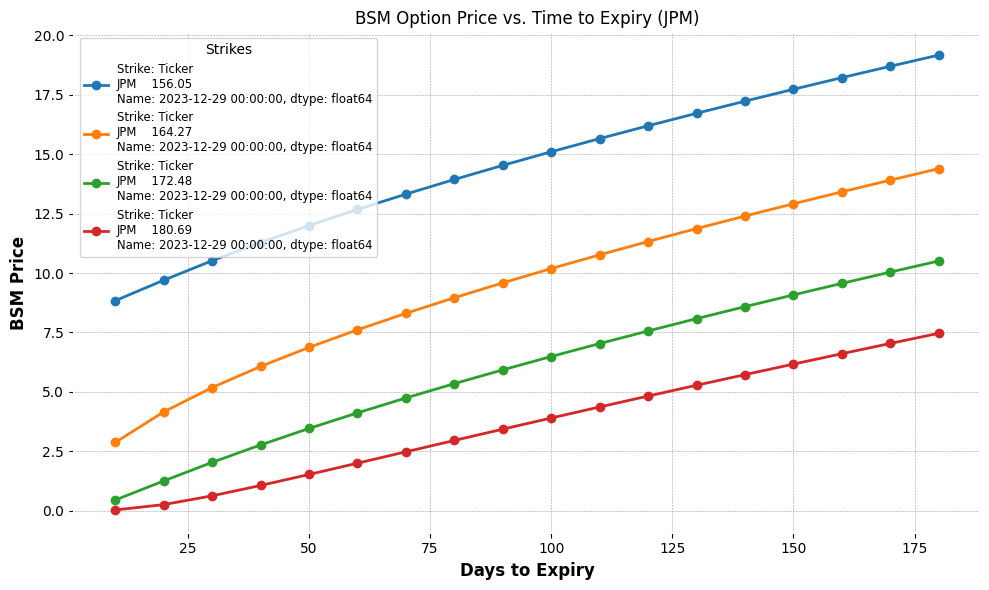

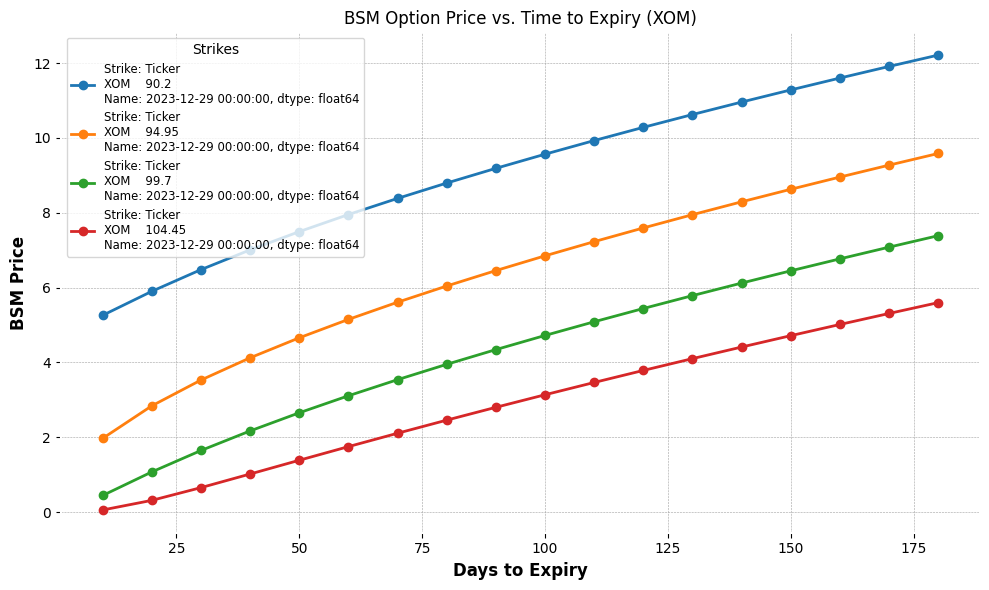

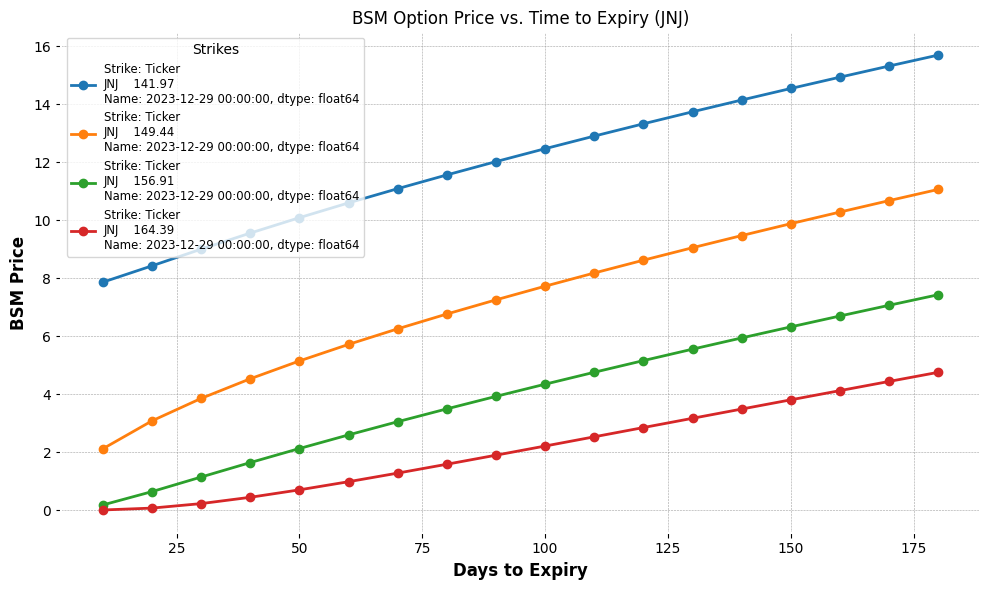

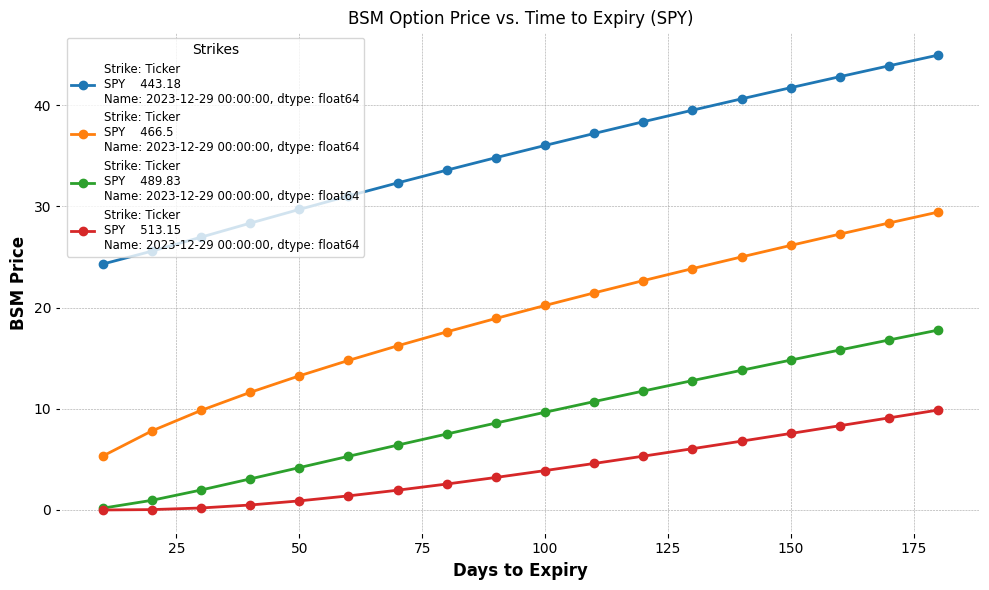

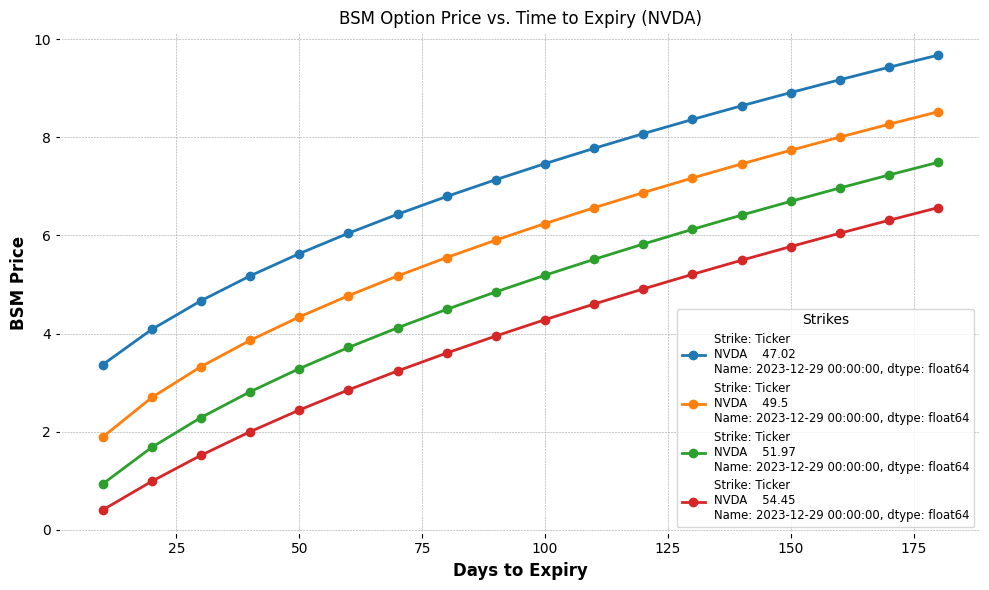

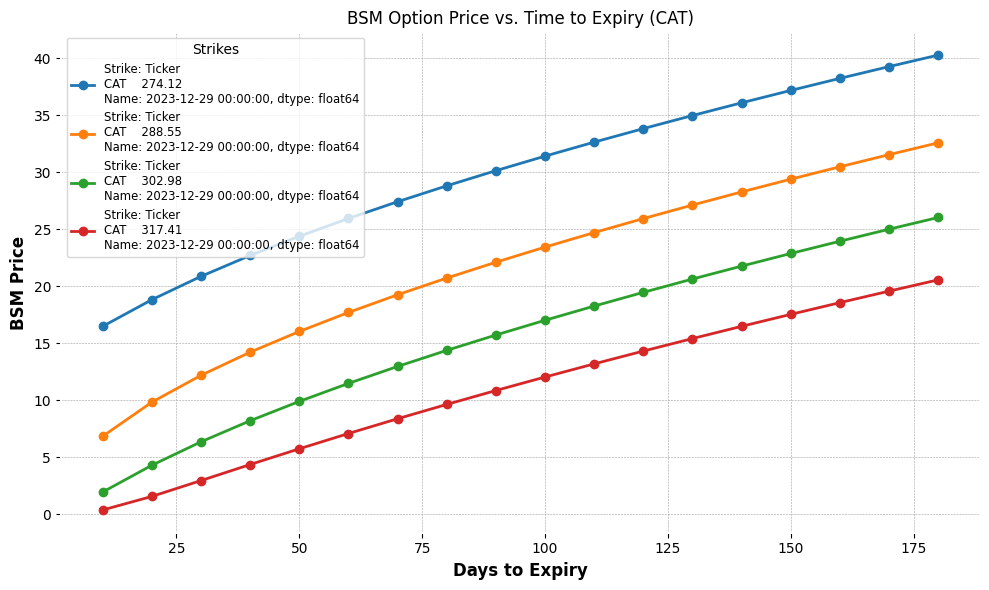

In [15]:
for ticker in results_df["Ticker"].unique():
    S = results_df[results_df["Ticker"] == ticker]["S"].values[-1]
    sigma = volatility_all[ticker]
    plot_price_vs_time_multi_strikes(S, sigma, r=0.05, ticker=ticker)


In [ ]:
import numpy as np
import pandas as pd

def monte_carlo_option_price(S0, K, T, r, sigma, num_simulations=10000, option_type='call'):
    Z = np.random.standard_normal(num_simulations)
    ST = float(S0) * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return np.exp(-r * T) * np.mean(payoffs)

r = 0.05
T_list = [30, 60, 90, 120, 150, 180]
monte_carlo_results = []

for ticker, df in data_all.items():
    df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))
    sigma = df["LogReturn"].std() * np.sqrt(252) 
    S = float(df["Close"].iloc[-1])  

    for T_days in T_list:
        T = T_days / 252
        K = round(S * 1.05, 2)

        mc_price = monte_carlo_option_price(S, K, T, r, sigma, option_type='call')

        monte_carlo_results.append({
            "Ticker": ticker,
            "S": S,
            "K": K,
            "T_days": T_days,
            "Volatility": sigma,
            "MC Price": round(mc_price, 4)
        })

monte_carlo_df = pd.DataFrame(monte_carlo_results)



C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\622661947.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(df["Close"].iloc[-1])  # Ensure scalar
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\622661947.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(df["Close"].iloc[-1])  # Ensure scalar
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\622661947.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = float(df["Close"].iloc[-1])  # Ensure scalar
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\622661947.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S = f

In [17]:
monte_carlo_df

,Ticker,S,K,T_days,Volatility,MC Price
0,AAPL,191.130341,200.69,30,0.199222,2.2108
1,AAPL,191.130341,200.69,60,0.199222,4.5729
2,AAPL,191.130341,200.69,90,0.199222,6.6737
3,AAPL,191.130341,200.69,120,0.199222,8.4829
4,AAPL,191.130341,200.69,150,0.199222,10.3182
5,AAPL,191.130341,200.69,180,0.199222,11.7613
6,TSLA,248.479996,260.90,30,0.523868,13.3064
7,TSLA,248.479996,260.90,60,0.523868,22.0610
8,TSLA,248.479996,260.90,90,0.523868,26.6798
9,TSLA,248.479996,260.90,120,0.523868,33.8391


In [ ]:
def plot_bsm_vs_monte_carlo(S, sigma, r, ticker, strike_multipliers=[0.95, 1.0, 1.05, 1.1], num_simulations=10000):
    T_days_range = np.arange(10, 181, 10)
    T_range = T_days_range / 252

    plt.figure(figsize=(12, 6))

    for m in strike_multipliers:
        K = round(S * m, 2)

        bsm_prices = [black_scholes_price(S, K, T, r, sigma) for T in T_range]
        mc_prices = [monte_carlo_option_price(S, K, T, r, sigma, num_simulations=num_simulations, option_type='call') for T in T_range]

        plt.plot(T_days_range, bsm_prices, label=f"BSM Strike {K}", linestyle='-')
        plt.plot(T_days_range, mc_prices, label=f"MC Strike {K}", linestyle='--')

    plt.title(f"BSM vs Monte Carlo Option Prices vs Time to Expiry ({ticker})")
    plt.xlabel("Days to Expiry")
    plt.ylabel("Option Price")
    plt.legend(title="Model & Strike", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"charts/{ticker}_bsm_vs_mc_price_vs_time.png", dpi=300)
    plt.show()


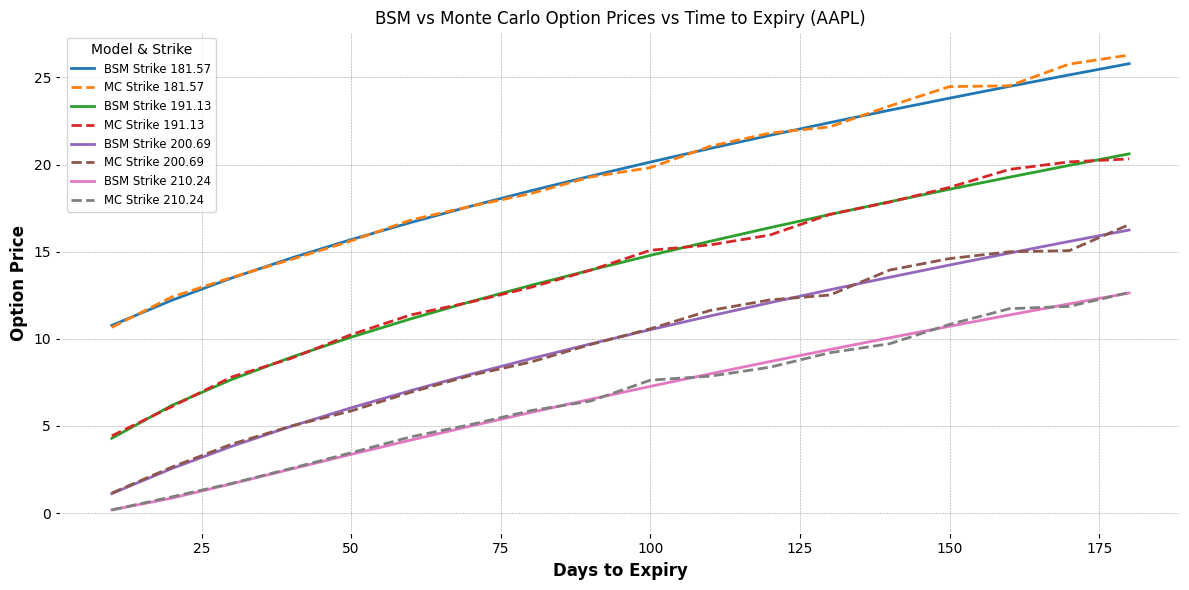

In [19]:
plot_bsm_vs_monte_carlo(S=191.13, sigma=0.27, r=0.05, ticker='AAPL')  # Example for AAPL


In [ ]:
def compare_real_vs_models(calls_df, S, sigma, r, ticker, expiry_str, num_simulations=10000):
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    calls_df = calls_df.copy()
    calls_df = calls_df[calls_df["inTheMoney"] == False]
    calls_df = calls_df[calls_df["bid"] > 0]
    calls_df["Mid"] = (calls_df["bid"] + calls_df["ask"]) / 2
    calls_df = calls_df.dropna(subset=["Mid", "strike", "lastTradeDate"])

    expiry_date = pd.to_datetime(expiry_str)
    calls_df["T_days"] = (expiry_date - pd.to_datetime(calls_df["lastTradeDate"]).dt.tz_localize(None)).dt.days
    calls_df = calls_df[calls_df["T_days"] > 0]

    bsm_prices = []
    mc_prices = []

    for _, row in calls_df.iterrows():
        K = row["strike"]
        T = row["T_days"] / 252

        bsm = black_scholes_price(S, K, T, r, sigma, option_type='call')
        mc = monte_carlo_option_price(S, K, T, r, sigma, num_simulations=num_simulations, option_type='call')

        bsm_prices.append(bsm)
        mc_prices.append(mc)

    calls_df["BSM Price"] = bsm_prices
    calls_df["MC Price"] = mc_prices

    plt.figure(figsize=(12, 6))
    plt.scatter(calls_df["T_days"], calls_df["Mid"], label="Real Market Price", color='black', alpha=0.7)
    plt.plot(calls_df["T_days"], calls_df["BSM Price"], label="BSM Model", linestyle='--', color='blue')
    plt.plot(calls_df["T_days"], calls_df["MC Price"], label="Monte Carlo", linestyle='-.', color='green')

    plt.title(f"{ticker} - Option Price Comparison (Exp: {expiry_str})")
    plt.xlabel("Days to Expiry")
    plt.ylabel("Call Option Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime

tickers = ["AAPL", "TSLA", "JPM", "XOM", "JNJ", "SPY", "NVDA", "CAT"]

all_calls = []
spot_prices = {}
today = pd.to_datetime(datetime.now().date())

for ticker in tickers:
    tk = yf.Ticker(ticker)

    try:
        spot_price = tk.history(period="1d")["Close"].iloc[-1]
        spot_prices[ticker] = spot_price
    except Exception as e:
        print(f"⚠️ Couldn't get spot price for {ticker}: {e}")
        continue

    try:
        expiry_dates = tk.options[:5]  
    except Exception as e:
        print(f"⚠️ Couldn't get expiry dates for {ticker}: {e}")
        continue

    for expiry in expiry_dates:
        try:
            calls = tk.option_chain(expiry).calls
            calls["Expiry"] = pd.to_datetime(expiry)
            calls["T_days"] = (calls["Expiry"] - today).dt.days
            calls["Ticker"] = ticker
            calls["Spot Price"] = spot_price
            calls["Mid Price"] = (calls["bid"] + calls["ask"]) / 2
            all_calls.append(calls)
        except Exception as e:
            print(f"⚠️ Failed to fetch options for {ticker} at {expiry}: {e}")
            continue

calls_df = pd.concat(all_calls, ignore_index=True)
calls_df = calls_df[["Ticker", "Expiry", "T_days", "strike", "Spot Price", "Mid Price", "impliedVolatility"]]
calls_df.dropna(subset=["Mid Price"], inplace=True)
calls_df.reset_index(drop=True, inplace=True)
calls_df


,Ticker,Expiry,T_days,strike,Spot Price,Mid Price,impliedVolatility
0,AAPL,2025-07-03,1,110.0,211.354507,101.000,0.00001
1,AAPL,2025-07-03,1,140.0,211.354507,70.975,0.00001
2,AAPL,2025-07-03,1,145.0,211.354507,65.975,0.00001
3,AAPL,2025-07-03,1,150.0,211.354507,61.025,0.00001
4,AAPL,2025-07-03,1,155.0,211.354507,55.975,0.00001


In [32]:
calls_df

,Ticker,Expiry,T_days,strike,Spot Price,Mid Price,impliedVolatility
0,AAPL,2025-07-03,1,110.0,211.354507,101.000,0.000010
1,AAPL,2025-07-03,1,140.0,211.354507,70.975,0.000010
2,AAPL,2025-07-03,1,145.0,211.354507,65.975,0.000010
3,AAPL,2025-07-03,1,150.0,211.354507,61.025,0.000010
4,AAPL,2025-07-03,1,155.0,211.354507,55.975,0.000010
...,...,...,...,...,...,...,...
2235,CAT,2025-08-01,30,405.0,396.552490,5.850,0.208046
2236,CAT,2025-08-01,30,410.0,396.552490,4.000,0.202584
2237,CAT,2025-08-01,30,415.0,396.552490,2.245,0.203072
2238,CAT,2025-08-01,30,420.0,396.552490,1.920,0.202828


In [33]:
import numpy as np

def monte_carlo_price_row(row, r=0.05, num_simulations=10000):
    S = row["Spot Price"]
    K = row["strike"]
    T = row["T_days"] / 252
    sigma = row["impliedVolatility"]

    # Fallback if volatility is 0 or missing
    if pd.isna(sigma) or sigma == 0:
        return np.nan

    Z = np.random.standard_normal(num_simulations)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    mc_price = np.exp(-r * T) * np.mean(payoffs)
    return round(mc_price, 4)


In [35]:
# Compute MC price per row
calls_df["MC_Price"] = calls_df.apply(monte_carlo_price_row, axis=1)

calls_df[["Ticker", "T_days", "strike", "Spot Price", "Mid Price", "impliedVolatility", "MC_Price"]].head()


,Ticker,T_days,strike,Spot Price,Mid Price,impliedVolatility,MC_Price
0,AAPL,1,110.0,211.354507,101.000,0.00001,101.3763
1,AAPL,1,140.0,211.354507,70.975,0.00001,71.3823
2,AAPL,1,145.0,211.354507,65.975,0.00001,66.3833
3,AAPL,1,150.0,211.354507,61.025,0.00001,61.3843
4,AAPL,1,155.0,211.354507,55.975,0.00001,56.3853


C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\480922684.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", len(sampled_strikes))


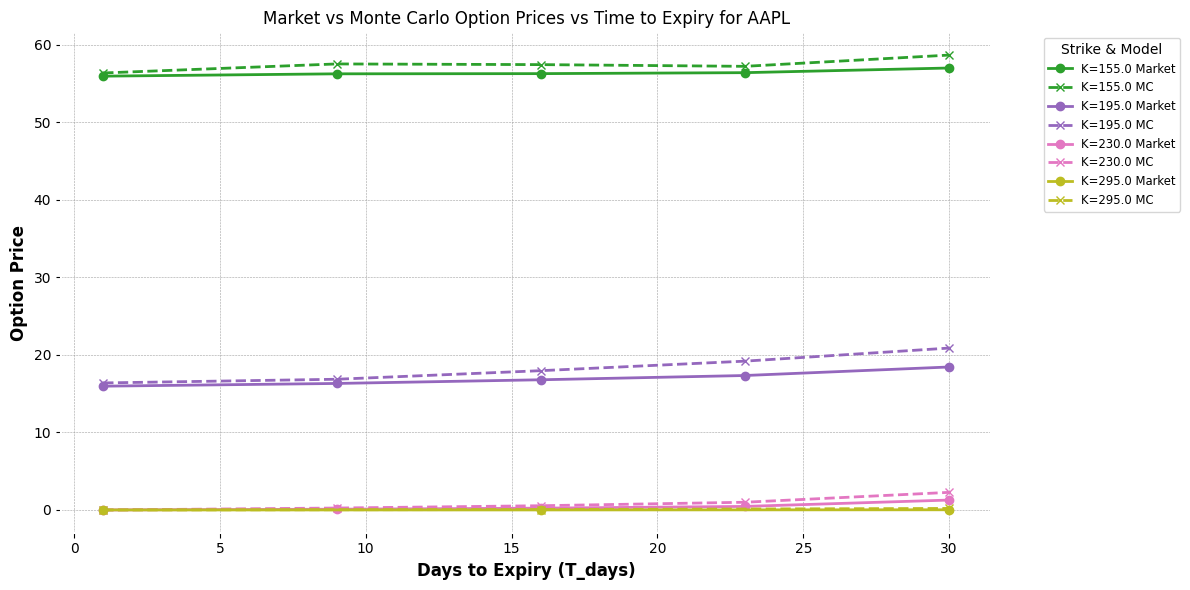

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

selected_ticker = "AAPL"
plot_df = calls_df[calls_df["Ticker"] == selected_ticker]
unique_strikes = sorted(plot_df["strike"].unique())
sampled_strikes = unique_strikes[::max(1, len(unique_strikes) // 5)]  

plt.figure(figsize=(12, 6))

color_map = plt.cm.get_cmap("tab10", len(sampled_strikes))

for idx, K in enumerate(sampled_strikes):
    sub = plot_df[plot_df["strike"] == K]
    if len(sub) < 2:
        continue

    color = color_map(idx)

    plt.plot(
        sub["T_days"],
        sub["Mid Price"],
        label=f"K={K} Market",
        linestyle='-',
        marker='o',
        color=color
    )
    plt.plot(
        sub["T_days"],
        sub["MC_Price"],
        label=f"K={K} MC",
        linestyle='--',
        marker='x',
        color=color
    )

plt.title(f"Market vs Monte Carlo Option Prices vs Time to Expiry for {selected_ticker}")
plt.xlabel("Days to Expiry (T_days)")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend(title="Strike & Model", fontsize="small", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compute_error_metrics(df, group_col="Ticker"):
    metrics = []

    for ticker, group in df.groupby(group_col):
        y_true = group["Mid Price"].values
        y_pred = group["MC_Price"].values

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)

        metrics.append({
            "Ticker": ticker,
            "MAE": round(mae, 4),
            "MSE": round(mse, 4),
            "RMSE": round(rmse, 4),
            "R² Score": round(r2, 4)
        })

    return pd.DataFrame(metrics)

error_metrics_df = compute_error_metrics(calls_df)
error_metrics_df


C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\2290945375.py:13: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\2290945375.py:13: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\2290945375.py:13: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\2290945375.py:13: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\2290945375.py:13: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\ashis\AppData\Local\Temp\ipykernel_18668\2290945375.py:13: RuntimeWarning: invalid value enco

,Ticker,MAE,MSE,RMSE,R² Score
0,AAPL,0.6333,0.8528,0.9235,0.9991
1,CAT,5.8439,421.1553,20.5221,0.8018
2,JNJ,0.7212,0.9277,0.9631,0.9971
3,JPM,3.5774,295.8107,17.1991,0.8064
4,NVDA,0.7259,1.2136,1.1016,0.9991
5,SPY,0.5371,0.7170,0.8467,0.9996
6,TSLA,1.2035,3.4307,1.8522,0.9992
7,XOM,0.6078,0.8957,0.9464,0.9923
